In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pyforest import *
from pandas_profiling import ProfileReport

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',150)
plt.rcParams['figure.figsize'] = (15, 6)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land", "wrong_fragment","urgent","hot","num_failed_logins","logged_in", "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login", "is_guest_login","count","srv_count","serror_rate","srv_serror_rate", "rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate", "dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate", "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

In [4]:
train = pd.read_csv('E:/_DATA SCIENCE/Projects/3. Network Intrusion Detection System/NSL_Dataset/Train.txt', header= None,names = columns)
test = pd.read_csv('E:/_DATA SCIENCE/Projects/3. Network Intrusion Detection System/NSL_Dataset/Test.txt',header= None,names = columns)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [8]:
print(test.dtypes.value_counts())
print(train.dtypes.value_counts())

int64      24
float64    15
object      4
dtype: int64
int64      24
float64    15
object      4
dtype: int64


In [9]:
# Creating Attack Class

def attack_class(attack_type = ''):
    attack_class = ''
    
    if attack_type in ['back','land','neptune','pod','smurf','teardrop','apache2','udpstorm','processtable','worm']:
        attack_class = 'dos'
    elif attack_type in ['satan','ipsweep','nmap','portsweep','mscan','saint']:
        attack_class = 'probe'
    elif attack_type in ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy','xlock', 'xsnoop', 'snmpgetattack', 'snmpguess', 'httptunnel', 'sendmail', 'named']:
        attack_class = 'r21'
    elif attack_type in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps']:
        attack_class = 'u2r'
    else:
        attack_class = 'normal'
    return attack_class

train['attack_class']= train.attack.apply(attack_class)
test['attack_class'] = train.attack.apply(attack_class)
train.drop('attack',inplace= True, axis=1)
test.drop('attack',inplace= True, axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 720x360 with 0 Axes>

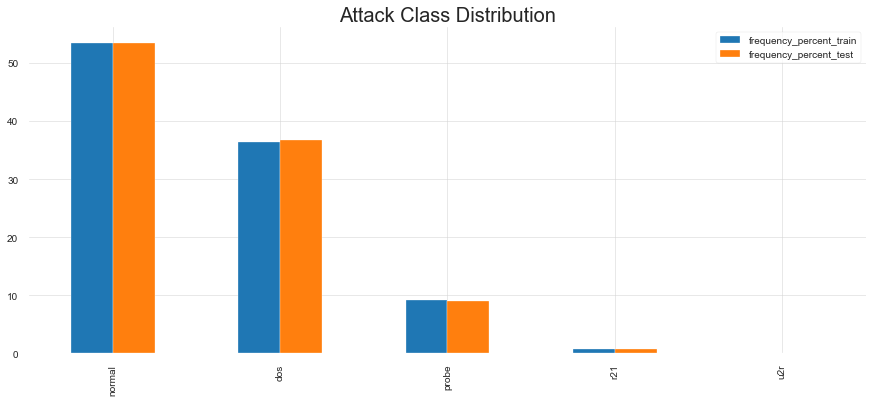

In [10]:
# Attack Class Distribution
attack_class_freq_train = train[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_test = test[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_train['frequency_percent_train'] = round((100 * attack_class_freq_train / attack_class_freq_train.sum()),2)
attack_class_freq_test['frequency_percent_test'] = round((100 * attack_class_freq_test / attack_class_freq_test.sum()),2)

attack_class_dist = pd.concat([attack_class_freq_train,attack_class_freq_test], axis=1)
plt.figure(figsize=(10,5))
plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar")
plot.set_title("Attack Class Distribution", fontsize=20)
plot.grid(color='lightgray', alpha=0.5)

In [11]:
## Label Encoder for Attack class
from sklearn.preprocessing import LabelEncoder
c_en = LabelEncoder()
c_en.fit(train.attack_class.unique())
train['attack_class'] = c_en.transform(train.attack_class)
test['attack_class'] = c_en.transform(test.attack_class)

In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125973.0,45566.743000,5.870331e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125973.0,19779.114421,4.021269e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125973.0,0.000198,1.408607e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125973.0,0.022687,2.535300e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.000111,1.436603e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.204409,2.149968e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125973.0,0.001222,4.523914e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,125973.0,0.395736,4.890101e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,125973.0,0.279250,2.394204e+01,0.0,0.00,0.00,0.00,7.479000e+03


In [13]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,22544.0,218.859076,1407.176612,0.0,0.00,0.00,0.0000,57715.0
src_bytes,22544.0,10395.450231,472786.431088,0.0,0.00,54.00,287.0000,62825648.0
dst_bytes,22544.0,2056.018808,21219.297609,0.0,0.00,46.00,601.0000,1345927.0
land,22544.0,0.000311,0.017619,0.0,0.00,0.00,0.0000,1.0
wrong_fragment,22544.0,0.008428,0.142599,0.0,0.00,0.00,0.0000,3.0
urgent,22544.0,0.000710,0.036473,0.0,0.00,0.00,0.0000,3.0
hot,22544.0,0.105394,0.928428,0.0,0.00,0.00,0.0000,101.0
num_failed_logins,22544.0,0.021647,0.150328,0.0,0.00,0.00,0.0000,4.0
logged_in,22544.0,0.442202,0.496659,0.0,0.00,0.00,1.0000,1.0
num_compromised,22544.0,0.119899,7.269597,0.0,0.00,0.00,0.0000,796.0


In [12]:
ProfileReport(train)

Number of variables,43
Number of observations,125973
Total Missing (%),0.0%
Total size in memory,40.8 MiB
Average record size in memory,340.0 B
Numeric,27
Categorical,3
Boolean,5
Date,0
Text (Unique),0
Rejected,8


In [13]:
ProfileReport(test)

Number of variables,43
Number of observations,22544
Total Missing (%),0.0%
Total size in memory,7.3 MiB
Average record size in memory,340.0 B
Numeric,27
Categorical,3
Boolean,5
Date,0
Text (Unique),0
Rejected,8


In [14]:
ls = ['service','num_shells','protocol_type','flag','su_attempted','urgent','wrong_fragment']
# Categorical features
cat_train = train[ls]
cat_test = test[ls]
# Numeric features
num_train = train.drop(ls,axis=1)
num_test = test.drop(ls,axis=1)

In [15]:
for x in ls:
    print('*'*55)
    print()
    print(f'No of unique values for {x} in train data: {len(cat_train[x].unique())}')
    print(f'No of unique values for {x} in test data: {len(cat_test[x].unique())}')
    print()       
print('*'*55)

*******************************************************

No of unique values for service in train data: 70
No of unique values for service in test data: 64

*******************************************************

No of unique values for num_shells in train data: 3
No of unique values for num_shells in test data: 4

*******************************************************

No of unique values for protocol_type in train data: 3
No of unique values for protocol_type in test data: 3

*******************************************************

No of unique values for flag in train data: 11
No of unique values for flag in test data: 11

*******************************************************

No of unique values for su_attempted in train data: 3
No of unique values for su_attempted in test data: 3

*******************************************************

No of unique values for urgent in train data: 4
No of unique values for urgent in test data: 4

**********************************************

In [16]:
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df   

# Creating Dummies
for x in ls:
    cat_train = create_dummies( cat_train, x )
    cat_test = create_dummies( cat_test, x )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
print(cat_train.shape)
print(cat_test.shape)

(125973, 90)
(22544, 85)


In [18]:
delcol_train = list()
delcol_test = list()
for x in cat_train.columns:
    if x not in cat_test.columns:
        delcol_train.append(x)

for x in cat_test.columns:
    if x not in cat_train.columns:
        delcol_test.append(x)

print(delcol_train)
print(delcol_test)

cat_train.drop(columns = delcol_train,inplace = True)
cat_test.drop(columns = delcol_test,inplace = True)

['service_aol', 'service_harvest', 'service_http_2784', 'service_http_8001', 'service_red_i', 'service_urh_i']
['num_shells_5']


In [19]:
ftrain = pd.concat([cat_train, num_train], axis=1)
ftest = pd.concat([cat_test, num_test], axis=1)
print(ftrain.shape)
print(ftest.shape)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(125973, 120)
(22544, 120)


In [20]:
x_train = ftrain.drop('attack_class',axis =1)
X_test = ftest.drop('attack_class',axis =1)
y_train = ftrain.attack_class

In [21]:
ls = list(x_train.columns)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train_scaled = pd.DataFrame(sc.fit_transform(x_train), columns =ls)
x_test_scaled = pd.DataFrame(sc.fit_transform(X_test), columns =ls)
x_train_scaled.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,num_shells_1,num_shells_2,protocol_type_tcp,protocol_type_udp,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,su_attempted_1,su_attempted_2,urgent_1,urgent_2,urgent_3,wrong_fragment_1,wrong_fragment_3,duration,src_bytes,dst_bytes,land,hot,num_failed_logins,logged_in,num_compromised,root_shell,num_root,num_file_creations,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,-0.02408,-0.083005,-0.087401,-0.075287,-0.076556,-0.065918,-0.067002,-0.064444,-0.065491,-0.06736,-0.278095,-0.058797,-0.194371,-0.158232,-0.062168,-0.061457,-0.119274,-0.118829,4.166943,-0.064257,-0.060539,-0.686328,-0.065,-0.071851,-0.07405,-0.058729,-0.048777,-0.057143,-0.061522,-0.058456,-0.059136,-0.059942,-0.056792,-0.052556,-0.053683,-0.053535,-0.070896,-0.048531,-0.036543,-0.189322,-0.0063,-0.024891,-0.045827,-0.02341,-0.458130,-0.024891,-0.026137,-0.022721,-0.248254,-0.044144,-0.049748,-0.055078,-0.065857,-0.061652,-0.137964,-0.00488,-0.007969,-0.07224,-0.069295,-0.078933,-0.074159,-0.070157,-0.074375,-0.018262,-0.0063,0.476175,-0.367555,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,-0.046432,-0.012912,-0.021647,-0.0063,-0.00488,-0.002817,-0.040472,-0.084065,-0.110249,-0.007679,-0.004919,-0.014089,-0.095076,-0.027023,-0.809262,-0.011664,-0.036652,-0.012385,-0.02618,-0.041221,0.0,-0.002817,-0.097531,-0.717045,-0.354343,-0.637209,-0.631929,-0.374362,-0.374432,0.771283,-0.349683,-0.374560,-0.324063,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,0.216426
1,-0.02408,-0.083005,-0.087401,-0.075287,-0.076556,-0.065918,-0.067002,-0.064444,-0.065491,-0.06736,-0.278095,-0.058797,-0.194371,-0.158232,-0.062168,-0.061457,-0.119274,-0.118829,-0.239984,-0.064257,-0.060539,-0.686328,-0.065,-0.071851,-0.07405,-0.058729,-0.048777,-0.057143,-0.061522,-0.058456,-0.059136,-0.059942,-0.056792,-0.052556,-0.053683,-0.053535,-0.070896,-0.048531,-0.036543,5.281999,-0.0063,-0.024891,-0.045827,-0.02341,-0.458130,-0.024891,-0.026137,-0.022721,-0.248254,-0.044144,-0.049748,-0.055078,-0.065857,-0.061652,-0.137964,-0.00488,-0.007969,-0.07224,-0.069295,-0.078933,-0.074159,-0.070157,-0.074375,-0.018262,-0.0063,-2.100067,2.720684,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,-0.046432,-0.012912,-0.021647,-0.0063,-0.00488,-0.002817,-0.040472,-0.084065,-0.110249,-0.007737,-0.004919,-0.014089,-0.095076,-0.027023,-0.809262,-0.011664,-0.036652,-0.012385,-0.02618,-0.041221,0.0,-0.002817,-0.097531,-0.620982,-0.368110,-0.637209,-0.631929,-0.374362,-0.374432,-1.321428,0.482201,-0.374560,0.734343,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

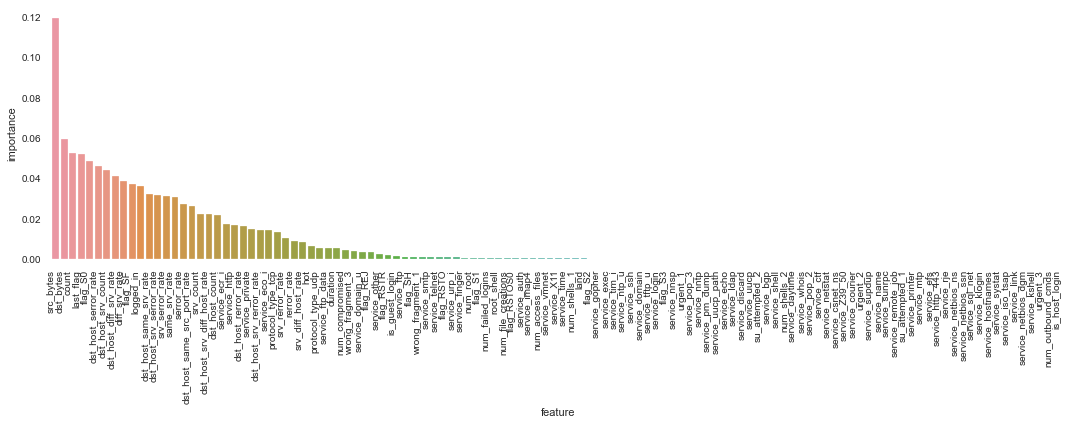

In [22]:
from sklearn.ensemble import RandomForestClassifier
samplecols =x_train_scaled.columns.values
X = x_train_scaled
y = y_train
rfc = RandomForestClassifier(random_state=123,criterion='entropy')
rfc.fit(X,y)
score = np.argsort(rfc.feature_importances_)[::-1]
feature_rank= pd.DataFrame(columns=['rank','feature','importance'])

for f in range(x_train_scaled.shape[1]):
 feature_rank.loc[f]=[f+1,
                      x_train_scaled.columns[score[f]],
                      rfc.feature_importances_[score[f]]]

ax = sns.barplot(x='feature',y='importance',data = feature_rank)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

In [23]:
list(feature_rank.feature[0:30])
top30 = list(feature_rank.feature[0:30])
top30

['src_bytes',
 'dst_bytes',
 'count',
 'last_flag',
 'flag_S0',
 'dst_host_serror_rate',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'diff_srv_rate',
 'flag_SF',
 'logged_in',
 'dst_host_same_srv_rate',
 'dst_host_srv_serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'serror_rate',
 'dst_host_same_src_port_rate',
 'srv_count',
 'dst_host_srv_diff_host_rate',
 'dst_host_count',
 'service_ecr_i',
 'service_http',
 'dst_host_rerror_rate',
 'service_private',
 'dst_host_srv_rerror_rate',
 'service_eco_i',
 'protocol_type_tcp',
 'srv_rerror_rate',
 'rerror_rate',
 'srv_diff_host_rate']

In [24]:
train_final =pd.concat([x_train_scaled, ftrain.attack_class], axis=1)
test_final =pd.concat([x_test_scaled, ftest.attack_class], axis=1)
train_final.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,num_shells_1,num_shells_2,protocol_type_tcp,protocol_type_udp,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,su_attempted_1,su_attempted_2,urgent_1,urgent_2,urgent_3,wrong_fragment_1,wrong_fragment_3,duration,src_bytes,dst_bytes,land,hot,num_failed_logins,logged_in,num_compromised,root_shell,num_root,num_file_creations,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,attack_class
0,-0.02408,-0.083005,-0.087401,-0.075287,-0.076556,-0.065918,-0.067002,-0.064444,-0.065491,-0.06736,-0.278095,-0.058797,-0.194371,-0.158232,-0.062168,-0.061457,-0.119274,-0.118829,4.166943,-0.064257,-0.060539,-0.686328,-0.065,-0.071851,-0.07405,-0.058729,-0.048777,-0.057143,-0.061522,-0.058456,-0.059136,-0.059942,-0.056792,-0.052556,-0.053683,-0.053535,-0.070896,-0.048531,-0.036543,-0.189322,-0.0063,-0.024891,-0.045827,-0.02341,-0.458130,-0.024891,-0.026137,-0.022721,-0.248254,-0.044144,-0.049748,-0.055078,-0.065857,-0.061652,-0.137964,-0.00488,-0.007969,-0.07224,-0.069295,-0.078933,-0.074159,-0.070157,-0.074375,-0.018262,-0.0063,0.476175,-0.367555,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,-0.046432,-0.012912,-0.021647,-0.0063,-0.00488,-0.002817,-0.040472,-0.084065,-0.110249,-0.007679,-0.004919,-0.014089,-0.095076,-0.027023,-0.809262,-0.011664,-0.036652,-0.012385,-0.02618,-0.041221,0.0,-0.002817,-0.097531,-0.717045,-0.354343,-0.637209,-0.631929,-0.374362,-0.374432,0.771283,-0.349683,-0.374560,-0.324063,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,0.216426,1
1,-0.02408,-0.083005,-0.087401,-0.075287,-0.076556,-0.065918,-0.067002,-0.064444,-0.065491,-0.06736,-0.278095,-0.058797,-0.194371,-0.158232,-0.062168,-0.061457,-0.119274,-0.118829,-0.239984,-0.064257,-0.060539,-0.686328,-0.065,-0.071851,-0.07405,-0.058729,-0.048777,-0.057143,-0.061522,-0.058456,-0.059136,-0.059942,-0.056792,-0.052556,-0.053683,-0.053535,-0.070896,-0.048531,-0.036543,5.281999,-0.0063,-0.024891,-0.045827,-0.02341,-0.458130,-0.024891,-0.026137,-0.022721,-0.248254,-0.044144,-0.049748,-0.055078,-0.065857,-0.061652,-0.137964,-0.00488,-0.007969,-0.07224,-0.069295,-0.078933,-0.074159,-0.070157,-0.074375,-0.018262,-0.0063,-2.100067,2.720684,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,-0.046432,-0.012912,-0.021647,-0.0063,-0.00488,-0.002817,-0.040472,-0.084065,-0.110249,-0.007737,-0.004919,-0.014089,-0.095076,-0.027023,-0.809262,-0.011664,-0.036652,-0.012385,-0.02618,-0.041221,0.0,-0.002817,-0.097531,-0.620982,-0.368110,-0.637209,-0.631929,-0.374362,-0.374432,-1.321428,0.482201,-0.374560,0.734343,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-

In [25]:
# Attack class in Encoder
c_en.classes_

array(['dos', 'normal', 'probe', 'r21', 'u2r'], dtype=object)

In [26]:
# Normal (1) DOS (0)
dos_df = train_final[(train_final.attack_class == 0) | (train_final.attack_class == 1)]
print('Train(DOS):', dos_df.shape)
dos_test_df = test_final[(test_final.attack_class == 0) | (test_final.attack_class == 1)]
print('Test(DOS):', dos_df.shape)

print('*'*55)

# Normal (1) PROBE (2)
dos_df = train_final[(train_final.attack_class == 2) | (train_final.attack_class == 1)]
print('Train(DOS):', dos_df.shape)
dos_test_df = test_final[(test_final.attack_class == 2) | (test_final.attack_class == 1)]
print('Test(DOS):', dos_df.shape)

print('*'*55)

# Normal (1) R2L (3)
dos_df = train_final[(train_final.attack_class == 3) | (train_final.attack_class == 1)]
print('Train(DOS):', dos_df.shape)
dos_test_df = test_final[(test_final.attack_class == 3) | (test_final.attack_class == 1)]
print('Test(DOS):', dos_df.shape)

print('*'*55)

# Normal (1) R2R (4)
dos_df = train_final[(train_final.attack_class == 4) | (train_final.attack_class == 1)]
print('Train(DOS):', dos_df.shape)
dos_test_df = test_final[(test_final.attack_class == 4) | (test_final.attack_class == 1)]
print('Test(DOS):', dos_df.shape)

Train(DOS): (113270, 120)
Test(DOS): (113270, 120)
*******************************************************
Train(DOS): (78999, 120)
Test(DOS): (78999, 120)
*******************************************************
Train(DOS): (68338, 120)
Test(DOS): (68338, 120)
*******************************************************
Train(DOS): (67395, 120)
Test(DOS): (67395, 120)


In [27]:
from sklearn.model_selection import train_test_split
x = x_train_scaled[top30]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3, random_state=111)

<IPython.core.display.Javascript object>

******************************
DecisionTreeClassifier
recall:99.8015%
precision:99.8035%
Time taken by DecisionTreeClassifierClassifier: 0:00:00.450761


<IPython.core.display.Javascript object>

******************************
RandomForestClassifier
recall:99.9418%
precision:99.9418%
Time taken by RandomForestClassifierClassifier: 0:00:22.639203


<IPython.core.display.Javascript object>

******************************
AdaBoostClassifier
recall:50.4842%
precision:62.2874%
Time taken by AdaBoostClassifierClassifier: 0:00:08.763488


<IPython.core.display.Javascript object>

******************************
LogisticRegression
recall:97.8646%
precision:98.2245%
Time taken by LogisticRegressionClassifier: 0:00:09.912319


<IPython.core.display.Javascript object>

****************************************


<IPython.core.display.Javascript object>

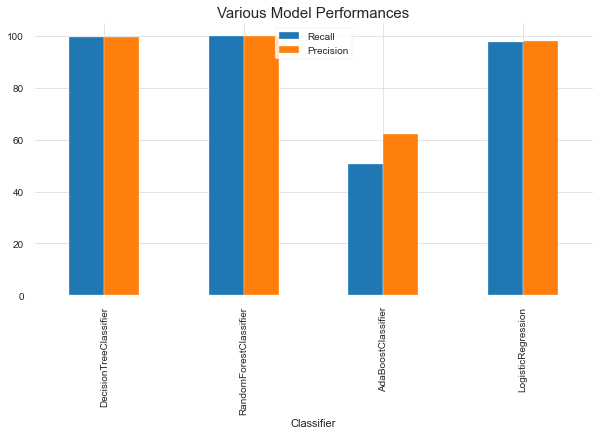

In [29]:
from sklearn.metrics import accuracy_score,log_loss,recall_score,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import datetime

from sklearn.utils import class_weight

classifiers = [DecisionTreeClassifier(max_features=0.7,random_state=123),
               RandomForestClassifier(max_features=0.7,random_state=123,criterion='entropy'),
               AdaBoostClassifier(random_state= 111),
               LogisticRegression(class_weight='balanced',random_state= 123)]

log_col = ['Classifier','Recall','Precision']
log = pd.DataFrame(columns = log_col)


for clf in classifiers:
    start = datetime.datetime.now()
    
    clf.fit(x_train,y_train)
    name = clf.__class__.__name__
    
    print('*'*30)
    print(name)
    
    train_predictions = clf.predict(x_test)
    recall = recall_score(y_test,train_predictions,average = 'weighted')
    precision = precision_score(y_test,train_predictions,average = 'weighted')
    print("recall:{:.4%}".format(recall))
    print('precision:{:.4%}'.format(precision))
    
    end = datetime.datetime.now()
    
    print(f'Time taken by {name}Classifier: {end-start}')
    
    log_entry = pd.DataFrame([[name,recall*100,precision*100]],columns=log_col)
    log = log.append(log_entry)
    
print("*"*40)
# Various models performance plot
log.set_index('Classifier', inplace=True)

plt.rcParams['figure.figsize'] = (10, 5)
plot = log[['Recall', 'Precision']].plot(kind="bar")
plot.set_title("Various Model Performances", fontsize=15)
plot.grid(color='lightgray', alpha=0.6)

In [31]:
from sklearn.ensemble import VotingClassifier

rf = RandomForestClassifier(max_features= 0.6,random_state = 112, criterion= 'gini')
dt = DecisionTreeClassifier(max_features=0.7, random_state= 112,criterion='gini')
ab = AdaBoostClassifier(random_state= 111)
lr = LogisticRegression(class_weight='balanced',random_state=11)

combined_model = [('RandomForest',rf),
                  ('DecisionTree',dt),
                  ('Ada Boost',ab),
                  ('LogisticRegresion',lr)]

v = VotingClassifier(estimators = combined_model,voting = 'soft')

v.fit(x_train,y_train)

VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(max_features=0.6,
                                                     random_state=112)),
                             ('DecisionTree',
                              DecisionTreeClassifier(max_features=0.7,
                                                     random_state=112)),
                             ('Ada Boost',
                              AdaBoostClassifier(random_state=111)),
                             ('LogisticRegresion',
                              LogisticRegression(class_weight='balanced',
                                                 random_state=11))],
                 voting='soft')

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

print()
print(classification_report(y_test,v.predict(x_test)))
print()
cm = confusion_matrix(y_test,v.predict(x_test))
plt.title('CONFUSION MATRIX (TRAINED MODEL)')
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('PREDICTED VALUE')
plt.ylabel('TRUE VALUE')

# Prediction on given Test Dataset

In [31]:
X_test = x_test_scaled[top30]
Y_test = test.attack_class

--------------- CLASSIFICATION REPORT ---------------

              precision    recall  f1-score   support

           0       0.37      0.28      0.32      8271
           1       0.53      0.60      0.56     12042
           2       0.09      0.11      0.10      2037
           3       0.03      0.01      0.02       183
           4       0.00      0.00      0.00        11

   micro avg       0.43      0.43      0.43     22544
   macro avg       0.20      0.20      0.20     22544
weighted avg       0.43      0.43      0.43     22544



Text(92.86111111111111, 0.5, 'TRUE VALUE')

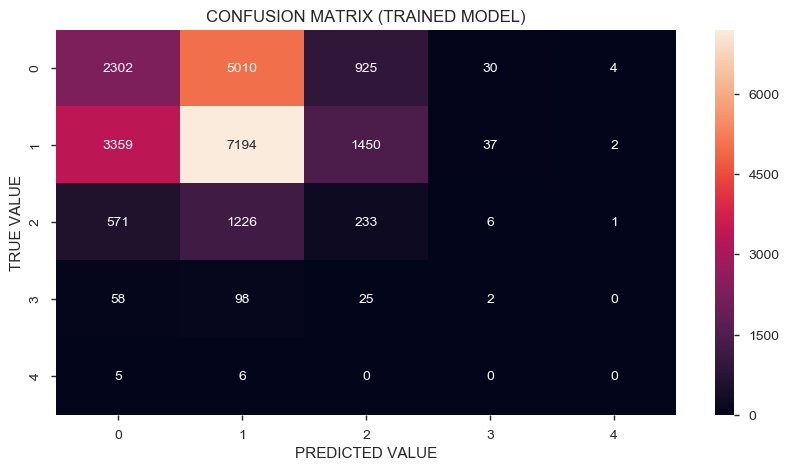

In [32]:
# X_test = ftest.drop('attack_flag',axis =1)
# Y_test = test.attack_flag
print('--------------- CLASSIFICATION REPORT ---------------')
print()
print(classification_report(Y_test, v.predict(X_test)))

cmt = confusion_matrix(Y_test, v.predict(X_test))

# Plotting confusion matrix
plt.title('CONFUSION MATRIX (TRAINED MODEL)')
sns.heatmap(cmt, annot=True, fmt='g')
plt.xlabel('PREDICTED VALUE')
plt.ylabel('TRUE VALUE')